# Introduction

Dans le cadre de ce projet, nous nous engageons dans la conception avancée d'un système de recommandation pour les animes de MyAnimeList (MAL). Notre initiative est guidée par une approche méthodique, exploitant des techniques d'apprentissage supervisé et non supervisé pour affiner la précision des suggestions offertes aux utilisateurs. L'objectif fondamental est d'exploiter de manière optimale les vastes ensembles de données disponibles sur MAL, afin de générer des recommandations qui sont à la fois personnalisées et contextuellement pertinentes.

Notre stratégie s'articule autour d'une fusion harmonieuse de deux paradigmes de recommandation primordiaux : le Collaborative Filtering et le Content-Based Filtering. Le premier s'appuie sur une analyse approfondie des interactions et des préférences des utilisateurs, formant ainsi la base d'une recommandation axée sur la communauté. Par contraste, le Content-Based Filtering se concentre sur les attributs intrinsèques des animes eux-mêmes, visant à identifier et à suggérer des titres ayant des caractéristiques similaires.

Au-delà de ces approches, notre exploration s'étendra à diverses méthodes analogues. Ces techniques supplémentaires seront soigneusement intégrées pour renforcer la pertinence et l'exactitude des recommandations. L'ambition ultime de ce projet est de forger un système de recommandation qui ne se contente pas de refléter les préférences actuelles des utilisateurs, mais qui est également capable d'anticiper et de satisfaire leur curiosité pour des animes inexplorés, enrichissant ainsi leur expérience de découverte.

In [576]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fitter import Fitter

from scipy.stats import pearsonr, kruskal

import html
import warnings

In [577]:
warnings.filterwarnings("ignore")

In [578]:
!pip install fitter

# Anime Dataset
## Importation et description des données

In [579]:
anime_df = pd.read_csv(r'../data/anime.csv', encoding='utf-8')

anime_df = anime_df.applymap(lambda x: html.unescape(x) if isinstance(x, str) else x)
anime_df.head(20)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama',"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama': Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [580]:
anime_df.shape

(12294, 7)

In [581]:
anime_df.columns.tolist()

['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']

In [582]:
anime_df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

In [583]:
anime_df_unique = {
    col: anime_df[col].unique().tolist()
    for col in anime_df[['type', 'genre']].columns
}

anime_df_unique

{'type': ['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA', nan],
 'genre': ['Drama, Romance, School, Supernatural',
  'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen',
  'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
  'Sci-Fi, Thriller',
  'Comedy, Drama, School, Shounen, Sports',
  'Action, Adventure, Shounen, Super Power',
  'Drama, Military, Sci-Fi, Space',
  'Drama, Fantasy, Romance, Slice of Life, Supernatural',
  'Drama, School, Shounen',
  'Action, Drama, Mecha, Military, Sci-Fi, Super Power',
  'Adventure, Drama, Supernatural',
  'Drama, Music, Romance, School, Shounen',
  'Adventure, Fantasy, Historical, Mystery, Seinen, Slice of Life, Supernatural',
  'Fantasy, Slice of Life',
  'Action, Mecha, Military, School, Sci-Fi, Super Power',
  'Comedy, Drama, Shounen, Sports',
  'Action, Drama, Historical, Martial Arts, Romance, Samurai',
  'Action, Adventure, Comedy, Drama, Sci-Fi, Space',
  'Action, Comedy, Parody, Sci-Fi, Seinen, Super Power, Superna

## Imputation et suppression des données manquantes et dupliquées

In [584]:
unknown_number_episodes = anime_df[anime_df == "Unknown"].count()

missing_rate = pd.DataFrame({
                             'count': (anime_df.isna().sum() + unknown_number_episodes),
                             'rate': (anime_df.isna().sum() * 100 / anime_df.shape[0]) 
                                      + (unknown_number_episodes * 100 / anime_df.shape[0])
                             }).sort_values(by = 'rate', ascending = False)
missing_rate

,count,rate
episodes,340,2.765577
rating,230,1.870831
genre,62,0.504311
type,25,0.203351
anime_id,0,0.000000
name,0,0.000000
members,0,0.000000


In [585]:
nan_ratings = anime_df[anime_df.rating.isna()]
nan_ratings

,anime_id,name,genre,type,episodes,rating,members
8968,34502,Inazma Delivery,"Action, Comedy, Sci-Fi",TV,10,NaN,32
9657,34309,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...,"Comedy, Supernatural",TV,Unknown,NaN,129
10896,34096,Gintama (2017),"Action, Comedy, Historical, Parody, Samurai, S...",TV,Unknown,NaN,13383
10897,34134,One Punch Man 2,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,Unknown,NaN,90706
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999
...,...,...,...,...,...,...,...
12274,34492,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,Hentai,OVA,Unknown,NaN,392
12279,34491,Sagurare Otome The Animation,Hentai,OVA,1,NaN,79
12280,34312,Saimin Class,Hentai,OVA,Unknown,NaN,240
12282,34388,Shikkoku no Shaga The Animation,Hentai,OVA,Unknown,NaN,195


In [586]:
anime_df[anime_df.duplicated()]

,anime_id,name,genre,type,episodes,rating,members


In [587]:
anime_df.dropna(inplace=True)
anime_df.drop(anime_df.loc[anime_df.episodes == 'Unknown'].index, inplace=True)

anime_df.episodes = anime_df.episodes.astype(int)

## Calcul des variables de rang par popularité et par note moyenne

In [588]:
anime_df.rating_rank = anime_df.rating.rank(ascending=False, method="min")
anime_df.members_rank = anime_df.members.rank(ascending=False, method="min")

### Détection des anomalies (notes anormalement trop hautes ou basses)

## Analyse descriptive et exploratoire genre par genre

### Exploration des genres uniques et déconstruction des genres composés

In [589]:
single_genre = anime_df[anime_df.genre.str.count(",") == 0]
single_genre_counts = single_genre.genre.value_counts()
single_genre_counts

genre
Hentai           785
Comedy           500
Music            297
Kids             190
Dementia         137
Fantasy          110
Drama            104
Slice of Life     96
Adventure         78
Historical        67
Action            53
Sci-Fi            41
Sports            40
Ecchi             21
Magic             20
Horror            18
Mystery           18
Mecha             17
Romance           14
Supernatural      14
Psychological     13
Game              10
Shoujo             9
Shounen            9
School             7
Parody             6
Cars               5
Seinen             3
Harem              2
Samurai            2
Military           2
Demons             2
Yaoi               2
Thriller           1
Martial Arts       1
Vampire            1
Space              1
Name: count, dtype: int64

In [590]:
exploded_genre_df = anime_df.assign(unique_genre=anime_df['genre'].str.split(", ")).explode('unique_genre')
exploded_genre_df.reset_index(inplace=True)
exploded_genre_df.drop(columns='index', inplace=True)
exploded_genre_df.unique_genre

0               Drama
1             Romance
2              School
3        Supernatural
4              Action
             ...     
35196          Hentai
35197          Hentai
35198          Hentai
35199          Hentai
35200          Hentai
Name: unique_genre, Length: 35201, dtype: object

In [591]:
anime_genre_counts = exploded_genre_df.unique_genre.value_counts()
anime_genre_counts

unique_genre
Comedy           4483
Action           2748
Adventure        2293
Fantasy          2219
Sci-Fi           2028
Drama            1972
Shounen          1669
Kids             1550
Romance          1436
Slice of Life    1180
School           1164
Hentai           1099
Supernatural      993
Mecha             927
Music             832
Historical        787
Magic             742
Ecchi             627
Shoujo            587
Seinen            530
Sports            527
Mystery           482
Super Power       445
Military          415
Parody            397
Space             376
Horror            360
Harem             312
Demons            287
Martial Arts      258
Dementia          238
Psychological     226
Police            194
Game              170
Samurai           145
Vampire           100
Thriller           86
Cars               71
Shounen Ai         62
Shoujo Ai          54
Josei              52
Yuri               41
Yaoi               37
Name: count, dtype: int64

In [592]:
df_expanded = anime_df.drop("genre", axis=1).join(
    anime_df.genre
    .str.split(", ", expand=True)
    .stack()
    .reset_index(level=1, drop=True)
    .rename("genre")
)
stats_par_genre = df_expanded.groupby("genre").agg(
    {
        "rating": ["mean", "count"],
        "members": "sum",
    }
)
stats_par_genre.columns = [
    "rating_moyen",
    "nombre_notes",
    "membres_somme",
]

stats_par_genre["membres_somme"] = stats_par_genre["membres_somme"].round(1)
stats_par_genre["genre_rating_rank"] = stats_par_genre["rating_moyen"].rank(
    ascending=False, method="min"
)
stats_par_genre["genre_members_rank"] = stats_par_genre["membres_somme"].rank(
    ascending=False, method="min"
)
stats_par_genre["genre_rating_rank"] = stats_par_genre["genre_rating_rank"].astype(int)
stats_par_genre["genre_members_rank"] = stats_par_genre["genre_members_rank"].astype(
    int
)

stats_par_genre.sort_values(by="rating_moyen", ascending=False)

,rating_moyen,nombre_notes,membres_somme,genre_rating_rank,genre_members_rank
genre,,,,,
Josei,7.443077,52,2203920,1,37
Thriller,7.382326,86,10072531,2,24
Mystery,7.233880,482,26697384,3,12
Police,7.116237,194,4769176,4,33
Shounen,7.055848,1669,52358640,5,8
Psychological,7.010398,226,17176263,6,18
Military,7.006193,415,12148845,7,22
Supernatural,7.004340,993,56456163,8,5
Romance,6.999554,1436,65405383,9,3


### Visualisation des données des potentielles variables pertinentes

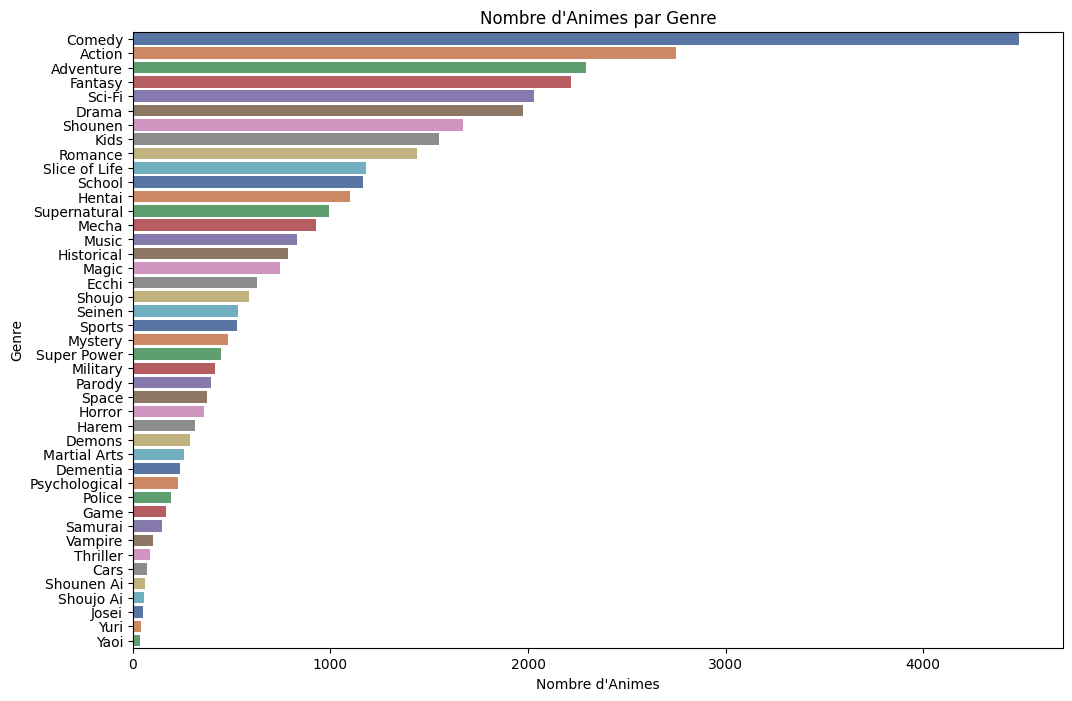

In [593]:
genre_counts = anime_genre_counts.reset_index()

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='count', y='unique_genre', data=genre_counts, ci=None, palette='deep')
plt.title('Nombre d\'Animes par Genre')
plt.xlabel('Nombre d\'Animes')
plt.ylabel('Genre')
plt.show()

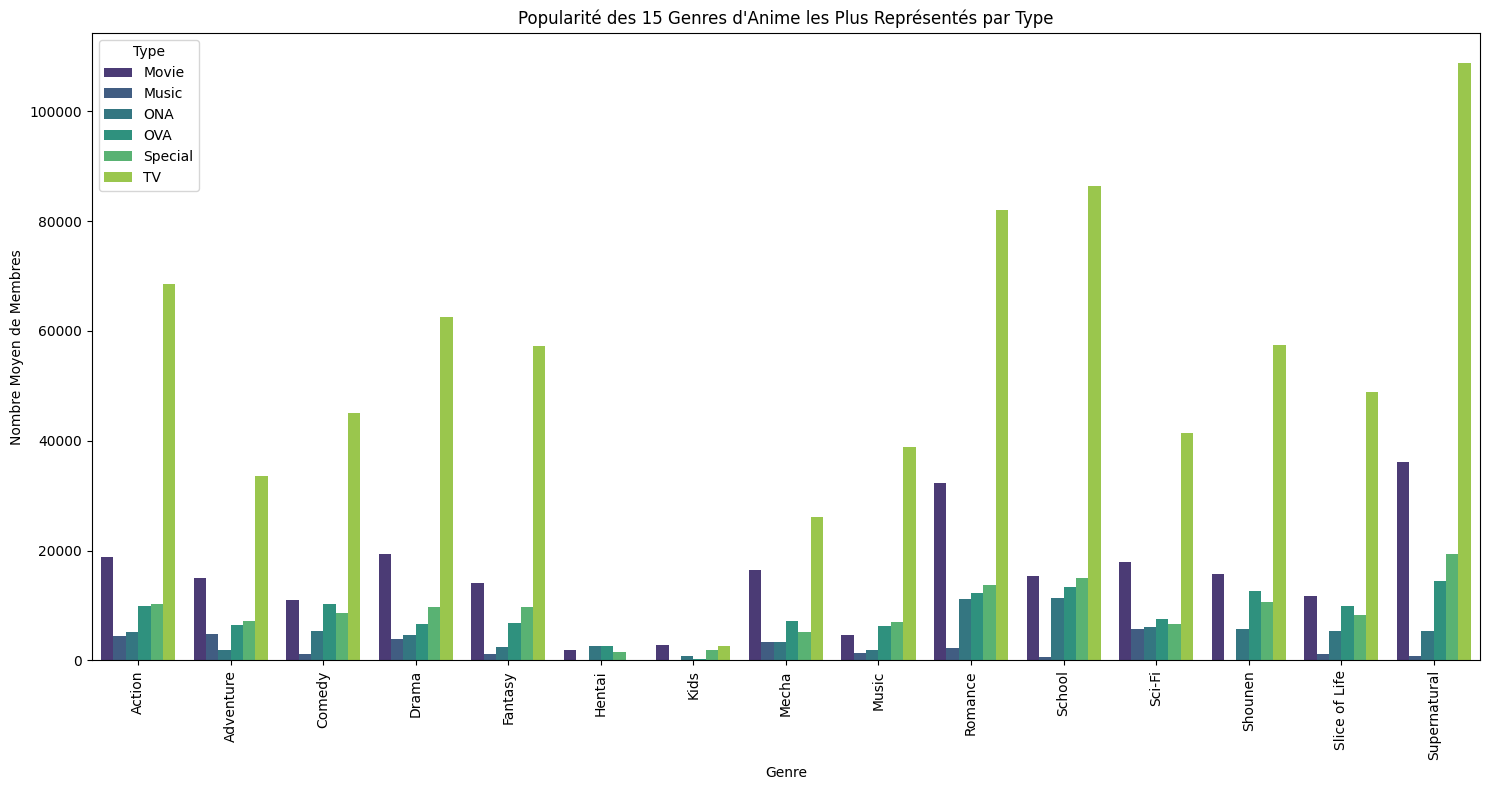

In [594]:
top_15_genres = exploded_genre_df['unique_genre'].value_counts().nlargest(15).index

filtered_data = exploded_genre_df[exploded_genre_df['unique_genre'].isin(top_15_genres)]

grouped_data = filtered_data.groupby(['unique_genre', 'type'])['members'].mean().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=grouped_data, x='unique_genre', y='members', hue='type', palette='viridis')

plt.xticks(rotation=90)
plt.title('Popularité des 15 Genres d\'Anime les Plus Représentés par Type')
plt.xlabel('Genre')
plt.ylabel('Nombre Moyen de Membres')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

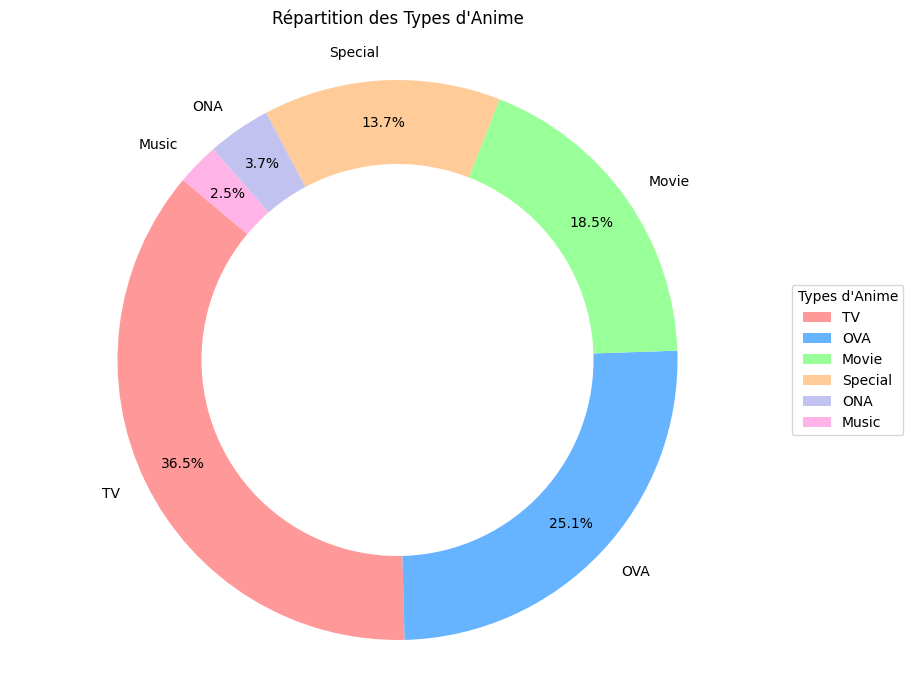

In [595]:
type_counts = exploded_genre_df['type'].value_counts()
labels = type_counts.index
sizes = type_counts.values

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0','#ffb3e6', '#c4e17f']

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.legend(labels, title="Types d'Anime", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Répartition des Types d\'Anime', pad=20)
plt.axis('equal')
plt.show()

### Tests paramétriques et non paramétriques 

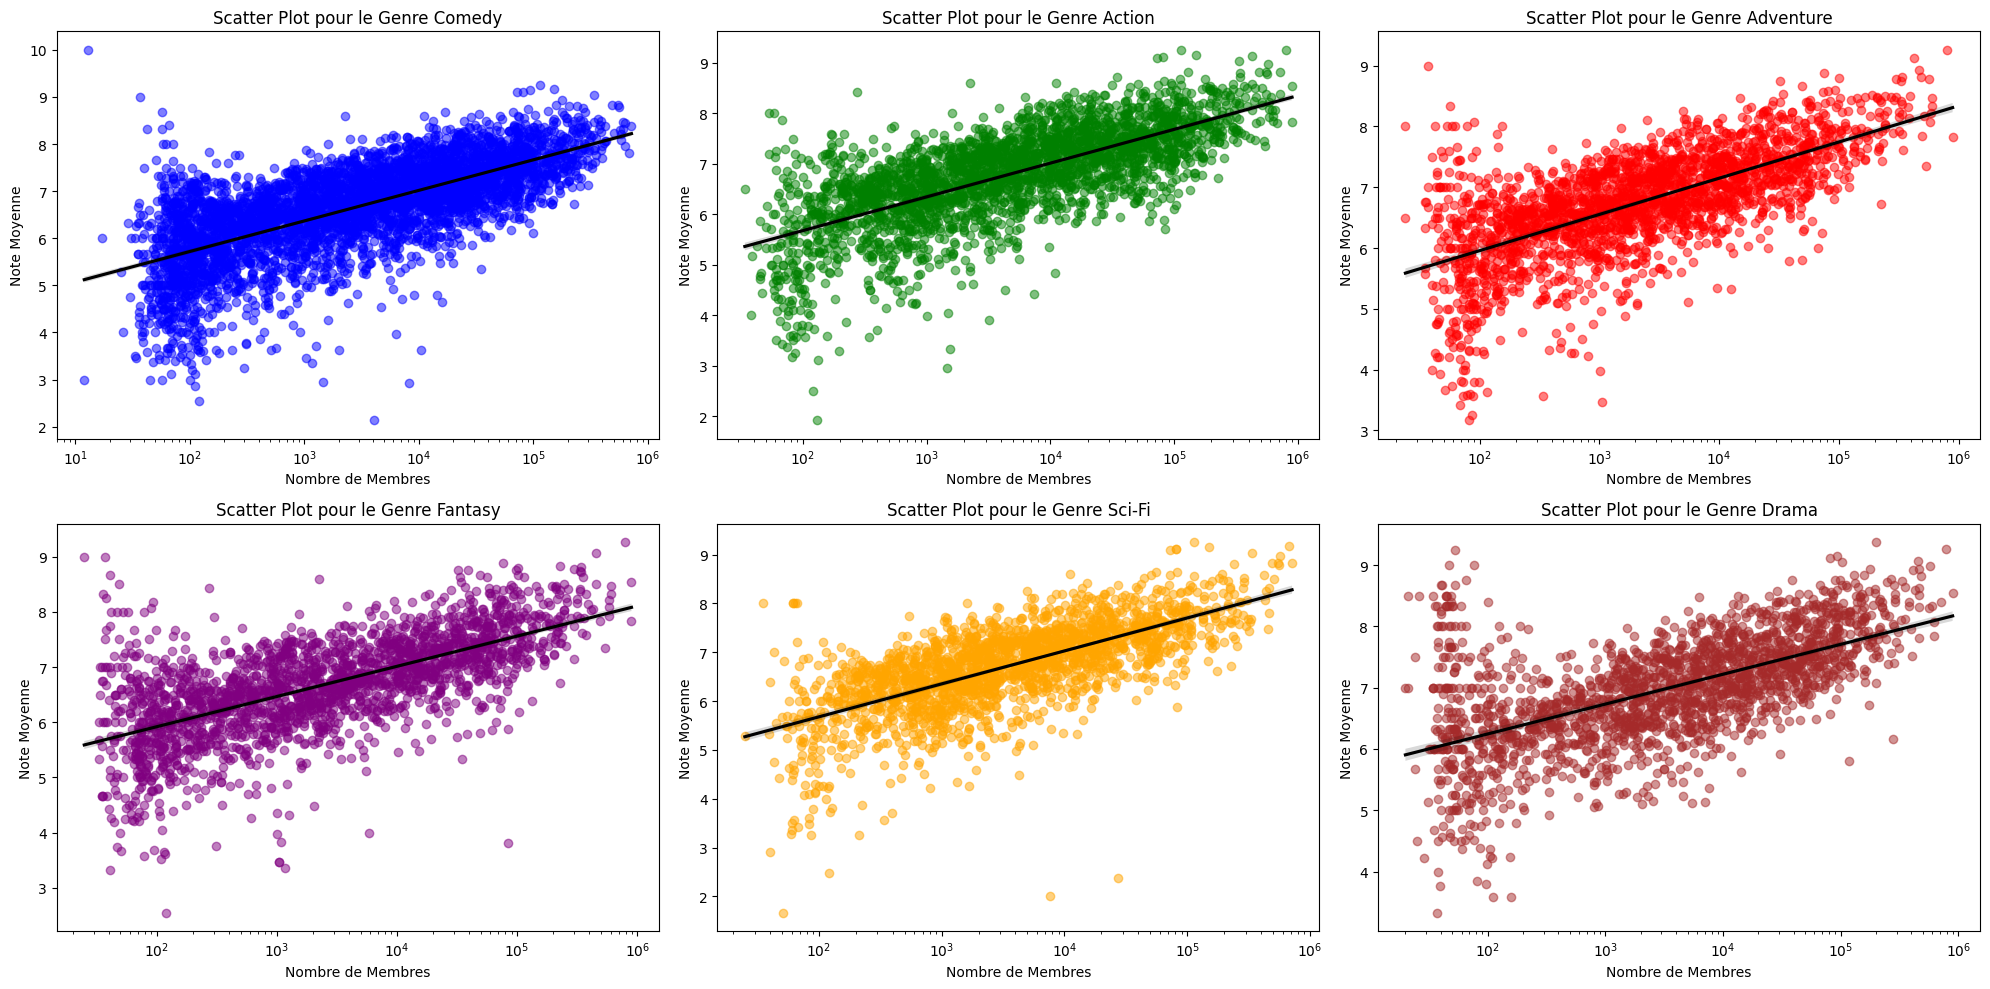

In [596]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

axes = axes.flatten()

top_genres = exploded_genre_df['unique_genre'].value_counts().nlargest(6).index.tolist()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

for i, genre in enumerate(top_genres):
    genre_df = exploded_genre_df[exploded_genre_df['unique_genre'] == genre]
    sns.regplot(ax=axes[i], data=genre_df, x='members', y='rating', 
                scatter_kws={'color': colors[i], 'alpha': 0.5},
                line_kws={'color': 'black'},
                logx=True)
    axes[i].set_title(f'Scatter Plot pour le Genre {genre}')
    axes[i].set_xlabel('Nombre de Membres')
    axes[i].set_ylabel('Note Moyenne')
    axes[i].set_xscale('log')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [597]:
columns_to_correlate = top_genres

correlation_with_rating = pd.DataFrame({
    'Genre': columns_to_correlate,
    'Correlation coefficient between the popularity and the rating': [
        pearsonr(exploded_genre_df[exploded_genre_df['unique_genre'] == genre]['members'],
                 exploded_genre_df[exploded_genre_df['unique_genre'] == genre]['rating'])[0]
        for genre in columns_to_correlate
    ]
})

correlation_with_rating_sorted = correlation_with_rating.sort_values(
    by='Correlation coefficient between the popularity and the rating',
    ascending=False
)

correlation_with_rating_sorted.reset_index(drop=True, inplace=True)
correlation_with_rating_sorted

,Genre,Correlation coefficient between the popularity and the rating
0,Drama,0.424566
1,Fantasy,0.420445
2,Action,0.417384
3,Sci-Fi,0.414145
4,Comedy,0.413826
5,Adventure,0.390236


SKIPPED gaussian distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
t,0.096026,743.939961,769.346450,inf,0.025133,9.493936e-20
dweibull,0.128443,740.804210,766.210699,inf,0.026818,1.993636e-22
norm,0.144145,889.505765,906.443424,inf,0.049458,2.869888e-75
f,0.151942,896.607136,930.482455,inf,0.050586,1.005179e-78
chi2,0.190113,946.615075,972.021564,inf,0.058736,5.274604e-106


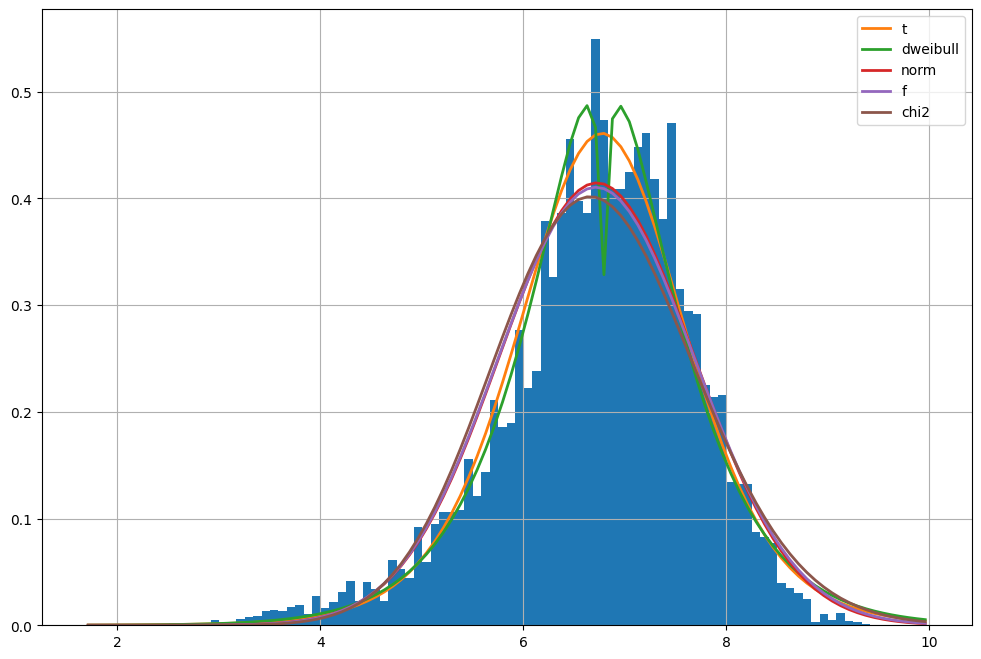

In [598]:
distribution_M2 = ["gaussian", "norm", "chi2", "cauchy", "expon", "f", "t", "gamma", "beta", "pareto", "uniform", "dweibull"]
f = Fitter(exploded_genre_df.rating, distributions=distribution_M2)
f.fit()

plt.figure(figsize=(12, 8))
plt.title('Distribution théorique et empirique des Notes')
f.summary()

SKIPPED gaussian distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,1.936622e-10,11913.210894,11947.086213,inf,0.166092,0.000000e+00
cauchy,4.509246e-10,3769.317282,3786.254941,inf,0.341729,0.000000e+00
pareto,1.166182e-09,3322.146524,3347.553014,inf,0.073853,2.045486e-167
expon,1.490588e-09,5740.361955,5757.299615,inf,0.396524,0.000000e+00
f,1.643469e-09,3304.937365,3338.812684,inf,0.097912,3.384151e-294


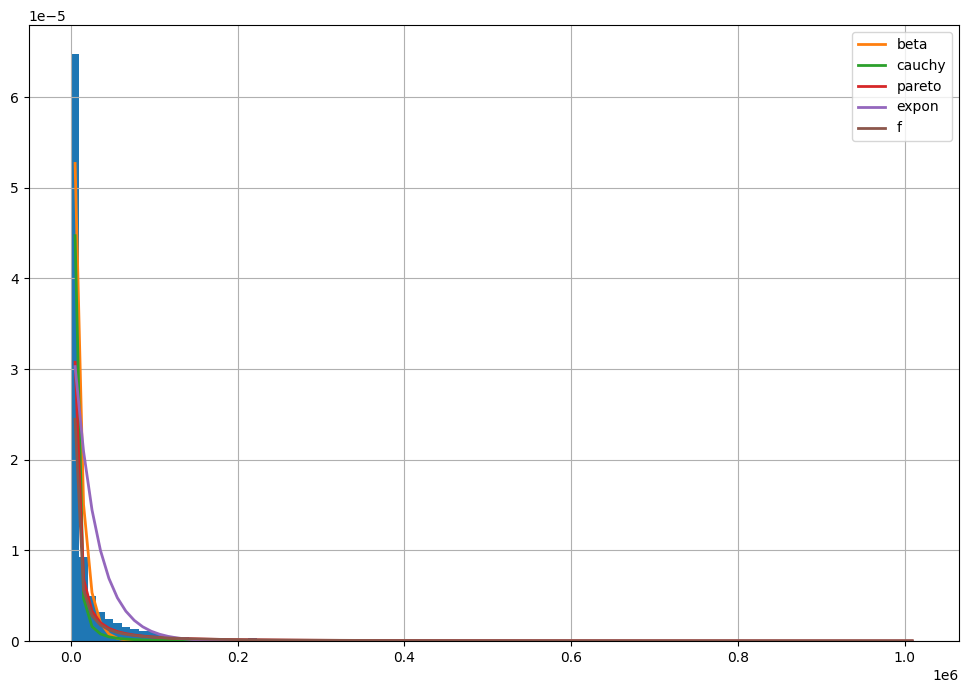

In [599]:
distribution_M2 = ["gaussian", "norm", "chi2", "cauchy", "expon", "f", "t", "gamma", "beta", "pareto", "uniform", "dweibull"]
f = Fitter(exploded_genre_df.members, distributions=distribution_M2)
f.fit()

plt.figure(figsize=(12, 8))
plt.title('Distribution théorique et empirique de la Popularité')
f.summary()

In [600]:
unique_types = exploded_genre_df.type.unique().tolist()

genre_data = [exploded_genre_df[exploded_genre_df['unique_genre'] == anime_genre]['rating'] for anime_genre in top_genres]
type_data = [exploded_genre_df[exploded_genre_df['type'] == anime_type]['rating'] for anime_type in unique_types]

genre_stat, genre_p_value = kruskal(*genre_data)
type_stat, type_p_value = kruskal(*type_data)

kruskal_results = pd.DataFrame({
    'Variable': ['genre', 'type'],
    'Statistic': [genre_stat, type_stat],
    'p-value': [genre_p_value, type_p_value],
    'Rejection': [genre_p_value < .05, type_p_value < .05]
})

kruskal_results

,Variable,Statistic,p-value,Rejection
0,genre,188.956038,6.530619e-39,True
1,type,4146.438120,0.000000e+00,True


# Rating Dataset

In [601]:
rating_df = pd.read_csv(r'../data/rating.csv')
rating_df.head(20)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


In [602]:
rating_df.shape

(7813737, 3)

In [603]:
rating_df.columns.tolist()

['user_id', 'anime_id', 'rating']

In [604]:
rating_df.dtypes


user_id     int64
anime_id    int64
rating      int64
dtype: object

In [605]:
missing_rate = pd.DataFrame({
                             'count': (rating_df.isna().sum()),
                             'rate': (rating_df.isna().sum() * 100 / rating_df.shape[0]) 
                            }).sort_values(by = 'rate', ascending = False)
missing_rate

,count,rate
user_id,0,0.0
anime_id,0,0.0
rating,0,0.0


In [606]:
total_animes_par_user = rating_df[rating_df["rating"] != -1].groupby("user_id")["anime_id"].count()

mean = total_animes_par_user.mean()
median = total_animes_par_user.median()
interquartile_range = total_animes_par_user.quantile(0.75) - total_animes_par_user.quantile(0.25)
kurtosis = total_animes_par_user.kurtosis()
flattening_coefficient = 3 - (6 / (total_animes_par_user.std() / total_animes_par_user.mean()))
dispersion_mean = total_animes_par_user.std() / total_animes_par_user.mean() * 100
dispersion_median = interquartile_range / median * 100

quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
quantiles_values = total_animes_par_user.quantile(quantiles)

statistics_watching_df = pd.DataFrame(
    {
        'Total des Anime vus par les Utilisateurs': [mean, median, interquartile_range, kurtosis, flattening_coefficient, dispersion_mean, dispersion_median]
                + quantiles_values.tolist()
    },
    index=['Mean' ,'Median', 'Interquartile Range', 'Kurtosis', 'Flattening Coefficient', 'Dispersion based on Mean',
           'Dispersion based on Median'] + [f'Quantile {int(q * 100)}%' for q in quantiles]
)

statistics_watching_df

,Total des Anime vus par les Utilisateurs
Mean,91.052313
Median,45.000000
Interquartile Range,101.000000
Kurtosis,40.570747
Flattening Coefficient,-1.023989
Dispersion based on Mean,149.105770
Dispersion based on Median,224.444444
Quantile 5%,2.000000
Quantile 25%,13.000000
Quantile 50%,45.000000


In [607]:
rating_df_noted = rating_df[rating_df["rating"] != -1]
anime_df.rename(columns={'rating': 'rating_mean'}, inplace=True)

anime_rating_df = pd.merge(rating_df_noted, anime_df, on='anime_id')

In [608]:
anime_rating_df

,user_id,anime_id,rating,name,genre,type,episodes,rating_mean,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
...,...,...,...,...,...,...,...,...,...
6337139,69964,23585,7,Haha wo Tazunete Sanzenri Specials,"Adventure, Drama, Slice of Life",Special,2,6.14,138
6337140,69964,33659,6,Fushigi na Somera-chan Special,"Comedy, Magic, Slice of Life",Special,1,5.15,444
6337141,72800,30738,4,Gamba: Gamba to Nakama-tachi,"Adventure, Kids",Movie,1,5.55,185
6337142,73135,8723,5,Anime Rakugo Kan,Comedy,OVA,4,5.84,264


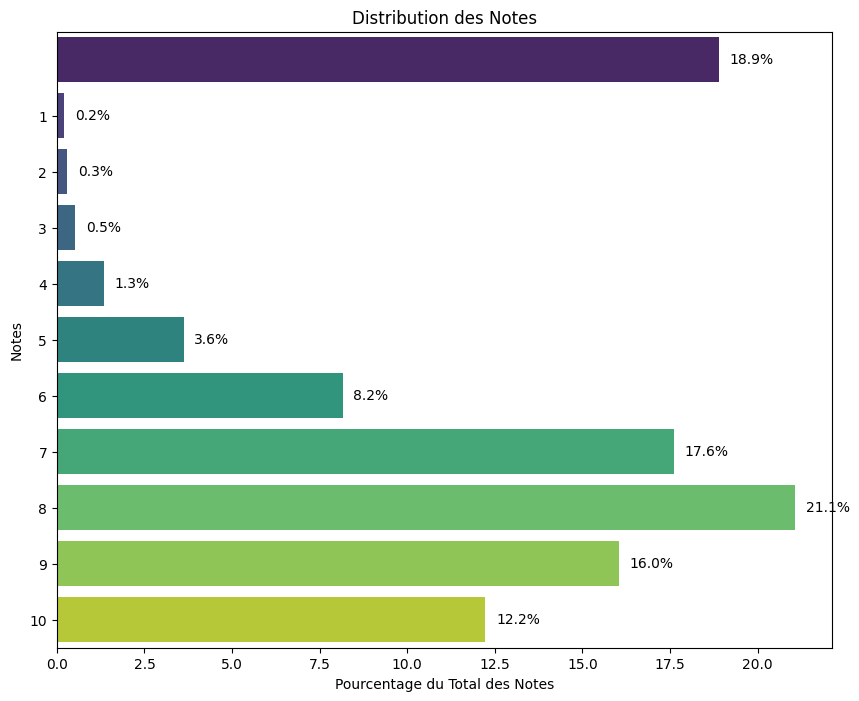

In [609]:
rating_counts = rating_df['rating'].value_counts()
total = rating_counts.sum()
percentages = (rating_counts / total) * 100
sorted_percentages = percentages.sort_index()

plt.figure(figsize=(10, 8))
ax = sns.barplot(x=sorted_percentages.values, y=sorted_percentages.index, orient='h', palette='viridis')

for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.3, p.get_y() + p.get_height() / 2, f'{width:.1f}%', va='center')

plt.title("Distribution des Notes")
plt.xlabel("Pourcentage du Total des Notes")
plt.ylabel("Notes")
plt.yticks(range(1, 11))
plt.show()

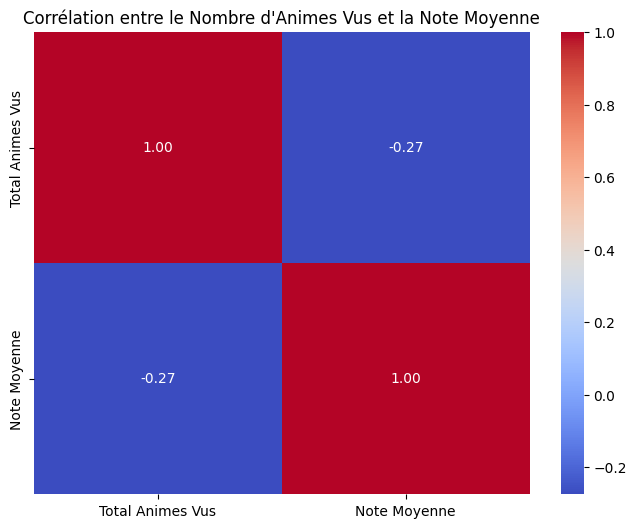

In [610]:
user_anime_counts = rating_df.groupby('user_id')['anime_id'].count()
user_rating_means = rating_df[rating_df['rating'] > 0].groupby('user_id')['rating'].mean()

user_data = pd.DataFrame({
    'Total Animes Vus': user_anime_counts,
    'Note Moyenne': user_rating_means
}).dropna()

corr_matrix = user_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélation entre le Nombre d'Animes Vus et la Note Moyenne")
plt.show()

In [611]:
columns_to_correlate = ['Total Animes Vus', 'Note Moyenne']

corr, p_value = pearsonr(user_data['Total Animes Vus'], user_data['Note Moyenne'])

correlation_result = pd.DataFrame({
    'Variables': ['Total Animes Vus vs Note Moyenne'],
    'Correlation Coefficient': [corr],
    'p-value': [p_value]
})

correlation_result

,Variables,Correlation Coefficient,p-value
0,Total Animes Vus vs Note Moyenne,-0.274915,0.0


In [612]:
def calculate_rating_threshold(rating_df, column_name='rating', quantile_high=0.75, quantile_low=0.25):
    """
    Calcule un seuil de notation en se basant sur des mesures statistiques.
    
    Args:
    - rating_df (pd.DataFrame): DataFrame contenant les notes.
    - column_name (str): Nom de la colonne contenant les notes.
    - quantile_high (float): Quantile supérieur pour définir les notes élevées.
    - quantile_low (float): Quantile inférieur pour définir les notes basses.

    Returns:
    - float: Seuil de notation calculé.
    """
    user_rating_counts = rating_df.groupby('user_id')[column_name].count()

    high_count_threshold = user_rating_counts.quantile(quantile_high)
    low_count_threshold = user_rating_counts.quantile(quantile_low)

    users_high = user_rating_counts[user_rating_counts >= high_count_threshold].index
    users_low = user_rating_counts[user_rating_counts <= low_count_threshold].index

    high_avg_rating = rating_df[rating_df['user_id'].isin(users_high)][column_name].mean()
    low_avg_rating = rating_df[rating_df['user_id'].isin(users_low)][column_name].mean()

    rating_threshold = np.mean([high_avg_rating, low_avg_rating])
    return rating_threshold

threshold = calculate_rating_threshold(rating_df)
print("Calculated Rating Threshold:", threshold)


Calculated Rating Threshold: 6.599470113744922


In [613]:
anime_rating_df

,user_id,anime_id,rating,name,genre,type,episodes,rating_mean,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
...,...,...,...,...,...,...,...,...,...
6337139,69964,23585,7,Haha wo Tazunete Sanzenri Specials,"Adventure, Drama, Slice of Life",Special,2,6.14,138
6337140,69964,33659,6,Fushigi na Somera-chan Special,"Comedy, Magic, Slice of Life",Special,1,5.15,444
6337141,72800,30738,4,Gamba: Gamba to Nakama-tachi,"Adventure, Kids",Movie,1,5.55,185
6337142,73135,8723,5,Anime Rakugo Kan,Comedy,OVA,4,5.84,264


In [614]:
def classify_users(rating_df, user_thresholds={'low': 0.25, 'medium': 0.50, 'high': 0.75, 'very_high': 0.90}):
    """
    Classifie les utilisateurs en fonction du nombre de leurs évaluations et d'un seuil de notation spécifié.

    Cette fonction regroupe les utilisateurs en catégories basées sur le nombre de notes qu'ils ont données.
    Elle utilise des seuils de quantiles pour définir ces catégories. De plus, les utilisateurs qui donnent
    fréquemment des notes en dessous d'un certain seuil sont classés comme 'Otaku'.

    Arguments :
    - rating_df (pd.DataFrame) : Un DataFrame pandas contenant au moins deux colonnes : 'user_id' et 'rating'.
    - user_thresholds (dict, optionnel) : Un dictionnaire spécifiant les seuils de quantile pour différentes catégories d'utilisateurs.
                                          Par défaut : {'low': 0.25, 'medium': 0.50, 'high': 0.75, 'very_high': 0.90}.
    - rating_threshold (float, optionnel) : Le seuil pour classer les utilisateurs comme 'Otaku' en fonction de leur note moyenne.
                                            Si None, ce seuil est calculé en utilisant la fonction calculate_rating_threshold.
    
    Retourne :
    - pd.DataFrame : Le DataFrame original avec une colonne supplémentaire 'category', qui contient la catégorie de chaque utilisateur.
    """
    user_stats = rating_df.groupby('user_id')['rating'].agg(['count', 'mean', 'std']).reset_index()

    low_count_threshold = user_stats['count'].quantile(user_thresholds['low'])
    medium_count_threshold = user_stats['count'].quantile(user_thresholds['medium'])
    high_count_threshold = user_stats['count'].quantile(user_thresholds['high'])
    very_high_count_threshold = user_stats['count'].quantile(user_thresholds['very_high'])

    bins = [0, low_count_threshold, medium_count_threshold, high_count_threshold, very_high_count_threshold, float('inf')]
    labels = ['Newfag', 'Casual', 'Oldfag', 'Otaku', 'Tastelet']
    user_stats['category'] = pd.cut(user_stats['count'], bins=bins, labels=labels, right=False)

    
    rating_df = rating_df.merge(user_stats[['user_id', 'category']], on='user_id', how='left')

    return rating_df

rating_df_noted = classify_users(rating_df_noted)



In [623]:
rating_df_noted[rating_df_noted['category'] == "Elitist"]

,user_id,anime_id,rating,category,average_rating
97,5,6,8,Elitist,4.355120
98,5,15,6,Elitist,4.355120
99,5,17,6,Elitist,4.355120
100,5,18,6,Elitist,4.355120
101,5,20,6,Elitist,4.355120
...,...,...,...,...,...
6336469,73503,32379,7,Elitist,6.418699
6336470,73503,32438,6,Elitist,6.418699
6336471,73503,32595,3,Elitist,6.418699
6336472,73503,32608,4,Elitist,6.418699


In [616]:
def adjust_user_category(rating_df, rating_threshold):
    """
    Ajuste la catégorie des utilisateurs dans le DataFrame selon que leur note moyenne est inférieure au seuil donné
    et qu'ils sont déjà classés comme 'Tastelet' ou 'Otaku'.
    """
    if 'category' not in rating_df.columns:
        raise KeyError("La colonne 'category' n'existe pas dans le DataFrame fourni.")

    user_average = rating_df.groupby('user_id')['rating'].mean().reset_index(name='average_rating')
    rating_df = rating_df.merge(user_average, on='user_id', how='left')

    # Étendre les catégories existantes pour inclure 'Elitist'.
    if 'Elitist' not in rating_df['category'].cat.categories:
        rating_df['category'] = rating_df['category'].cat.add_categories(['Elitist'])

    # Mise à jour de la catégorie à 'Elitist' si les conditions sont remplies.
    rating_df.loc[(rating_df['category'].isin(['Tastelet', 'Otaku'])) & (rating_df['average_rating'] < rating_threshold), 'category'] = 'Elitist'

    return rating_df


In [617]:
rating_df_noted = adjust_user_category(rating_df_noted, calculate_rating_threshold(rating_df))

In [618]:
rating_df_noted

,user_id,anime_id,rating,category,average_rating
0,1,8074,10,Newfag,10.000000
1,1,11617,10,Newfag,10.000000
2,1,11757,10,Newfag,10.000000
3,1,15451,10,Newfag,10.000000
4,2,11771,10,Newfag,10.000000
...,...,...,...,...,...
6337236,73515,16512,7,Otaku,8.547486
6337237,73515,17187,9,Otaku,8.547486
6337238,73515,22145,10,Otaku,8.547486
6337239,73516,790,9,Newfag,9.000000


In [619]:
user_stats = rating_df.groupby('user_id')['rating'].agg(['count', 'mean', 'std']).reset_index()
user_thresholds={'low': 0.25, 'medium': 0.50, 'high': 0.75, 'very_high': 0.90}
low_count_threshold = user_stats['count'].quantile(user_thresholds['low'])
medium_count_threshold = user_stats['count'].quantile(user_thresholds['medium'])
high_count_threshold = user_stats['count'].quantile(user_thresholds['high'])
very_high_count_threshold = user_stats['count'].quantile(user_thresholds['very_high'])

bins = [0, low_count_threshold, medium_count_threshold, high_count_threshold, very_high_count_threshold, float('inf')]
labels = ['Newfag', 'Casual', 'Oldfag', 'Otaku', 'Tastelet']
user_stats['category'] = pd.cut(user_stats['count'], bins=bins, labels=labels, right=False)

user_stats[user_stats['category'] == "Tastelet"]

,user_id,count,mean,std,category
4,5,467,4.263383,2.461116,Tastelet
6,7,343,7.387755,1.104786,Tastelet
16,17,601,4.351082,3.939738,Tastelet
42,43,284,7.630282,1.534272,Tastelet
45,46,334,8.565868,1.344604,Tastelet
...,...,...,...,...,...
73420,73422,324,7.067901,1.855880,Tastelet
73455,73457,374,7.500000,2.257843,Tastelet
73489,73491,345,-0.510145,2.171575,Tastelet
73497,73499,603,7.832504,1.217319,Tastelet


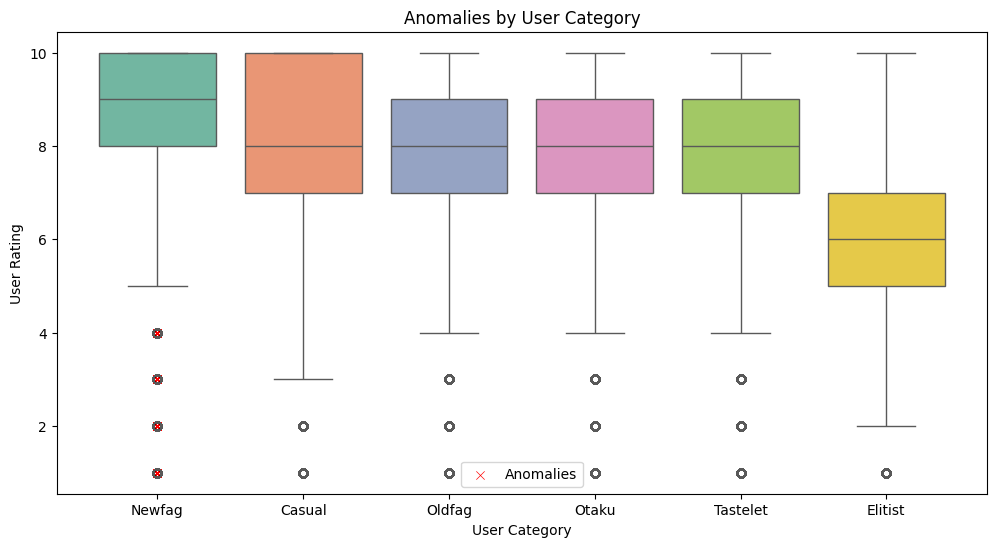

,user_id,anime_id,rating,category,average_rating,anomaly_type
0,143,747,4,Newfag,5.333333,Low
1,162,9310,4,Newfag,4.500000,Low
2,205,3455,4,Newfag,6.666667,Low
3,205,9181,4,Newfag,6.666667,Low
4,205,13663,4,Newfag,6.666667,Low
...,...,...,...,...,...,...
1056,73307,11887,1,Newfag,4.750000,Low
1057,73307,18245,1,Newfag,4.750000,Low
1058,73350,788,1,Newfag,1.000000,Low
1059,73381,15605,2,Newfag,8.142857,Low


In [625]:

def detect_anomalies_by_user_category(rating_df, user_category_column='category', rating_column='rating'):
    """
    Détecte les notes anormalement hautes et basses pour chaque catégorie d'utilisateurs.

    Arguments :
    - rating_df (pd.DataFrame) : DataFrame contenant les notes et les catégories d'utilisateurs.
    - user_category_column (str) : Nom de la colonne dans le DataFrame qui contient les catégories d'utilisateurs.
    - rating_column (str) : Nom de la colonne dans le DataFrame qui contient les notes des utilisateurs.

    Retourne :
    - pd.DataFrame : DataFrame contenant les anomalies détectées avec des informations supplémentaires.
    """
    anomalies = pd.DataFrame()

    for category in rating_df[user_category_column].unique():
        category_df = rating_df[rating_df[user_category_column] == category]
        
        Q1 = category_df[rating_column].quantile(0.25)
        Q3 = category_df[rating_column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        category_anomalies = category_df[(category_df[rating_column] < lower_bound) | (category_df[rating_column] > upper_bound)].copy()
        category_anomalies['anomaly_type'] = np.where(category_anomalies[rating_column] < lower_bound, 'Low', 'High')
        category_anomalies['category'] = category

        anomalies = pd.concat([anomalies, category_anomalies], ignore_index=True)

        plt.figure(figsize=(12, 6))
        sns.boxplot(x=user_category_column, y=rating_column, data=rating_df, palette="Set2")
        sns.scatterplot(x=user_category_column, y=rating_column, data=anomalies,
                        color='red', label='Anomalies', marker='x')

        plt.title('Anomalies by User Category')
        plt.xlabel('User Category')
        plt.ylabel('User Rating')
        plt.legend()
        plt.show()

        return anomalies

anomalies_df = detect_anomalies_by_user_category(rating_df_noted)
anomalies_df